# In this notebook we are going to build a music recommendation engine that would reccomend artists based on the lyrics of their songs. 

### First off we import our libraries

In [1]:
import lyricsgenius
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import requests
from urllib.request import urlopen
import bs4
from bs4 import BeautifulSoup
import re
import lxml.html
from lxml import html
from datetime import datetime, timedelta
import time
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import json
import boto3
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

nltk.download('stopwords')
stop = stopwords.words('english')
sno = SnowballStemmer('english')
secrets = json.load(open('secrets.json','r'))

genius = lyricsgenius.Genius(secrets['genius_key'])

ModuleNotFoundError: No module named 'lyricsgenius'

### Here we scrape a list of 100 rappers from Genuis

In [ ]:
dom = lxml.html.fromstring(requests.get('https://genius.com/discussions/22873-Greatest-100-rappers').content)
rappers = [x for x in dom.xpath('//li/text()')]
rappers = [i for i in rappers if '\n' not in i]

print(rappers)

### We find some more artists from billboard top 100 artists in the last "3" years

In [ ]:
base_url = "https://www.billboard.com/charts/artist-100/"
pop_big = []
for n in range(20):
    d = (datetime.now() - timedelta(days=60*n)).strftime('%Y-%m-%d')
    dom2 = lxml.html.fromstring(requests.get(base_url + d).content)
    pop = [x for x in dom2.xpath('//*[@class="chart-list-item__title-text"]/a/text()')]
    pop = [i[1:-1] for i in pop]
    pop_big += pop
    time.sleep(.1)
pop_big = list(set(pop_big))

print(pop_big)

### We do same for some dance artists. 



In [ ]:
dom3 = lxml.html.fromstring(requests.get('https://www.billboard.com/articles/news/dance/8504278/billboard-dance-100-2019').content)
electronic = [x for x in dom3.xpath('//p/strong/text()')]



print(electronic)

#### The data that are being scraped most often than not are dirty with HTML tags such as white spaces and the break tag and also some other irrevalant information. Therefore they are cleaned to return a a list of just the name of the artists in a list

In [ ]:
no_words = ['Top Gig of 2018:', 'Outlook:', 'Notable Stat:','Contributors: ']
electronic=[i for i in electronic if not any(words in i for words in no_words)]

electronic_fixed = []
for elec in electronic:
    electronic_fixed.append('. '.join(elec.split('. ')[1:]))
    
print(electronic_fixed)

### Then we just add all our artists together into one list

In [ ]:
artists=rappers+pop_big+electronic_fixed

artists = list(set(artists))

print(artists)


In [ ]:
len(artists)

### Optional step (not recommended) 

In [ ]:

artists = [art.replace('The Jungle Brothers', 'Jungle Brothers') for art in artists]
artists = [art.replace('The Funky Four+1', 'Funky Four Plus One') for art in artists]
artists = [art.replace('Kool Keith/Dr. Octagon', 'Kool Keith') for art in artists]





### Here we pull the lyrics for 10 songs per artist through the genuis API

In [ ]:
lyric_dict = {}
for art in artists:
    try:
        artist = genius.search_artist(art, max_songs=10,sort='popularity')
    except Exception as e:
        print(e)
        time.sleep(15)
        continue
    if artist is None:
        continue
    for song in artist.songs:
        #print(song.artist + ' ' + song.title)
        lyric_dict[song.artist + '____' + song.title] = song.lyrics

lyric_df = pd.DataFrame.from_dict(lyric_dict,orient='index').reset_index()
lyric_df.columns = ['song_and_artist','lyrics']

def get_artist(word):
    return word.split('____')[0]

def get_song(word):
    return word.split('____')[1]

lyric_df['artist'] = lyric_df['song_and_artist'].apply(get_artist)
lyric_df['song'] = lyric_df['song_and_artist'].apply(get_song)
lyric_df.drop('song_and_artist',axis=1,inplace=True)

In [ ]:
lyric_df.to_csv("lyric_df.csv", index=False)


### Here we pull the genre for each artist using the spotify API (you would need a spotify Client ID and a spotify secret key)


In [ ]:
def pull_genre(row):
    artist=row['artist'].replace(' ', '%20')
    CLIENT_ID = secrets['spotify_id']
    CLIENT_SECRET = secrets['spotify_secret']

    grant_type = 'client_credentials'
    body_params = {'grant_type' : grant_type}

    url='https://accounts.spotify.com/api/token'
    response = requests.post(url, data=body_params, auth = (CLIENT_ID, CLIENT_SECRET)) 

    token_raw = json.loads(response.text)
    token = token_raw["access_token"]
    headers = {"Authorization": "Bearer {}".format(token)}
    try:
        r = requests.get(url="https://api.spotify.com/v1/search?q={}&type=artist".format(artist), headers=headers)
        ret = json.loads(r.text)
        return ret['artists']['items'][0]['genres']
    except:
        return []

In [ ]:
#We create a new column 'Genre' and apply the above function to it

lyric_df['Genre'] = lyric_df.apply(pull_genre, axis=1)

### Then we clean the lyrics we scraped

In [ ]:
#First we create a function to handle the Html Tags
def clean_html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#then the punctuations
def clean_punc(word):
    cleaned = re.sub(r'[?|!|\'|#]', r'', word)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

#stemmatize
def text_preprocess(sentence):
    filtered_sentence = []
    for word in sentence.split():
        if word not in stop:
            s = sno.stem(word.lower())
            filtered_sentence.append(s)
        else:
            continue 
    return ' '.join(filtered_sentence)

#aaply the function to 'lyrics' column, create new column called 'Cleaned lyrics'
lyric_df['lyrics']  = lyric_df['lyrics'].apply(clean_punc)
lyric_df['lyrics']  = lyric_df['lyrics'].apply(clean_html)
lyric_df['Cleaned lyrics']  = lyric_df['lyrics'].apply(text_preprocess)

In [ ]:
#here I save my dataframe to csv for further analysis
lyric_df.to_csv("lyric_df.csv", index=False)


### Since I already pulled the lyrics and saved it to csv I'm just going to read it

In [1]:
import pandas as pd
ly_df = pd.read_csv('full_music.csv')

In [2]:
ly_df.isnull().values.any()


True

In [3]:
ly_df.isnull().sum().sum()


17

In [4]:
ly_df=ly_df.dropna()

In [5]:
ly_df.head()

,lyrics,artist,song,Genre,Cleaned lyrics
0,[Verse 1]\nHello its me\nI was wondering if a...,Adele,Hello,"['british soul', 'pop', 'uk pop']",[vers 1] hello i wonder year youd like meet to...
1,[Verse 1]\nI heard that youre settled down\nTh...,Adele,Someone Like You,"['british soul', 'pop', 'uk pop']",[vers 1] i heard your settl that found girl yo...
2,[Verse 1]\nI will leave my heart at the door\n...,Adele,All I Ask,"['british soul', 'pop', 'uk pop']",[vers 1] i leav heart door i wont say word the...
3,[Verse 1]\nEverybody loves the things you do\n...,Adele,When We Were Young,"['british soul', 'pop', 'uk pop']",[vers 1] everybodi love thing from way talk wa...
4,[Verse 1]\nTheres a fire starting in my heart\...,Adele,Rolling in the Deep,"['british soul', 'pop', 'uk pop']",[vers 1] there fire start heart reach fever pi...


In [6]:
ly_df.describe().transpose()


,count,unique,top,freq
lyrics,39040,38613,\n Lyrics for this song h...,180
artist,39040,4593,Maroon 5,10
song,39040,35192,Intro,18
Genre,39040,2542,[],7184
Cleaned lyrics,39040,38601,lyric song yet releas pleas check back song re...,181


In [7]:
ly_df = ly_df[ly_df.Genre!='[]']

In [8]:
#here I see that the rows of the 'Genre' column are lists in strings. They need to be lists entries.
ly_df['Genre'].iloc[0]

"['british soul', 'pop', 'uk pop']"

In [9]:
#the function below fixes the above problem
import ast
def make_list(str_list):
    return ast.literal_eval(str_list)
ly_df['Genre'] = ly_df.Genre.apply(make_list)

In [10]:
ly_df['Genre'].iloc[0]

['british soul', 'pop', 'uk pop']

In [11]:
#We would like the individual genres in the 'Genre' column to be its own column and binarize the entry in these
#depending on whether an artist belongs to that specific genre.

from sklearn.preprocessing import MultiLabelBinarizer

s = ly_df['Genre']

mlb2 = MultiLabelBinarizer()

s1 = pd.DataFrame(mlb2.fit_transform(s),columns=mlb2.classes_, index=ly_df.index)
s1.columns = ['genre_' + i for i in s1.columns]
s1.head()

,genre_21st century classical,genre_aarhus indie,genre_aberdeen indie,genre_abstract hip hop,genre_acid jazz,genre_acoustic blues,genre_acoustic pop,genre_adoracion,genre_adult standards,genre_afghan pop,...,genre_ye ye,genre_yodeling,genre_yugoslav new wave,genre_yugoslav rock,genre_zambian pop,genre_zapstep,genre_zim urban groove,genre_zolo,genre_zouglou,genre_zydeco
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
genre_df = ly_df.join(s1)

genre_df.head()

,lyrics,artist,song,Genre,Cleaned lyrics,genre_21st century classical,genre_aarhus indie,genre_aberdeen indie,genre_abstract hip hop,genre_acid jazz,...,genre_ye ye,genre_yodeling,genre_yugoslav new wave,genre_yugoslav rock,genre_zambian pop,genre_zapstep,genre_zim urban groove,genre_zolo,genre_zouglou,genre_zydeco
0,[Verse 1]\nHello its me\nI was wondering if a...,Adele,Hello,"[british soul, pop, uk pop]",[vers 1] hello i wonder year youd like meet to...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[Verse 1]\nI heard that youre settled down\nTh...,Adele,Someone Like You,"[british soul, pop, uk pop]",[vers 1] i heard your settl that found girl yo...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[Verse 1]\nI will leave my heart at the door\n...,Adele,All I Ask,"[british soul, pop, uk pop]",[vers 1] i leav heart door i wont say word the...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[Verse 1]\nEverybody loves the things you do\n...,Adele,When We Were Young,"[british soul, pop, uk pop]",[vers 1] everybodi love thing from way talk wa...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[Verse 1]\nTheres a fire starting in my heart\...,Adele,Rolling in the Deep,"[british soul, pop, uk pop]",[vers 1] there fire start heart reach fever pi...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2000,stop_words='english')
X = cv.fit_transform(genre_df['Cleaned lyrics'])
count_vect_df = pd.DataFrame(X.todense(), columns=['lyric_' + i for i in cv.get_feature_names()],index=genre_df.index)


Feature reduction: PCA/SVD/NMF

In [14]:
wide_df = genre_df.join(count_vect_df)

In [15]:
wide_df.shape

(31856, 3544)

### Prediction begins here

In [16]:
#Change string to other genres to predict for other genres
genre_string = 'hip hop'
new_col = 'is_{}'.format(genre_string)

In [17]:
wide_df[new_col]=0
wide_df.loc[wide_df[[i for i in list(wide_df) if (genre_string in i) and ('genre_' in i)]].sum(axis=1) > 0,new_col]=1

Predicting if a song is Hip Hop

In [18]:
prediction_df = wide_df[['artist','song', new_col] + [i for i in list(wide_df) if 'lyric_' in i]]
prediction_df[prediction_df[new_col]==1]

,artist,song,is_hip hop,lyric_10,lyric_100,lyric_12,lyric_20,lyric_21,lyric_2x,lyric_30,...,lyric_тебя,lyric_то,lyric_только,lyric_ты,lyric_что,lyric_эй,lyric_это,lyric_تو,lyric_ما,lyric_من
30,Ali Gatie,Moonlight,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,Ali Gatie,Can’t Lie,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,Ali Gatie,It’s You,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,Ali Gatie,Remedy,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,Ali Gatie,Losing You,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,Ali Gatie,Say to You,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,Ali Gatie,Nobody Like You,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,Ali Gatie,Without You,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,Ali Gatie,Only One,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,Ali Gatie,Lies,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(prediction_df[[i for i in list(prediction_df) if 'lyric_' in i]],
                                                    prediction_df[new_col], test_size=0.33, random_state=42)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'max_depth': [1,5,10,20,30,40],
#     'n_estimators': [100,500]
# }
#rf = RandomForestClassifier(max_depth=40, n_estimators=500)
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 3, n_jobs = 2, verbose = 2, scoring='auc')
#grid_search.fit(X_train,y_train)

In [21]:
#rf = RandomForestClassifier(n_estimators=50,max_depth=10)
rf = LogisticRegression()
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

rf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def plot_roc(test,pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(test, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    print(roc_auc_score(test, pred))
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.show()

0.8588314496100765


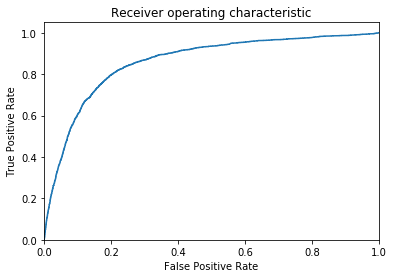

Training AUC
0.9284808703310543
Testing AUC
0.8588314496100765


In [23]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

X_test.fillna(0,inplace=True)

preds_train = rf.predict_proba(X_train)[:,1]
preds_test = rf.predict_proba(X_test)[:,1]
plot_roc(y_test,preds_test)
print('Training AUC')
print(roc_auc_score(y_train,preds_train))
print('Testing AUC')
print(roc_auc_score(y_test,preds_test))
#print(accuracy_score(y_train,preds))

In [24]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(20)

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [ ]:
prediction_df_new = prediction_df.copy()


rf.predict_proba(prediction_df_new[X_train.columns])

In [ ]:
prediction_df_new = prediction_df.copy()


prediction_df_new['pred_{}'.format(genre_string)] = rf.predict_proba(prediction_df_new[X_train.columns])[:, 1]

In [ ]:
rf.predict_proba(prediction_df_new[X_train.columns])

In [ ]:
prediction_df_new[['artist','song','pred_{}'.format(genre_string)]].sort_values('pred_{}'.format(genre_string),ascending=False).head(50)

Train a Log Reg

In [34]:
import statsmodels.api as sm

In [35]:
logit_model=sm.Logit(prediction_df[new_col],prediction_df[[i for i in list(prediction_df) if 'lyric_' in i]])

In [37]:
result=logit_model.fit()
result_summary = result.summary2()

Optimization terminated successfully.
         Current function value: 0.476504
         Iterations 7


In [44]:
result_summary.tables[1].sort_values('Coef.',ascending=False).head(50)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
lyric_intro,0.577002,0.038593,14.950798,1.538932e-50,0.501360,0.652643
lyric_rap,0.304805,0.029469,10.343355,4.485516e-25,0.247047,0.362562
lyric_hook,0.206539,0.016848,12.258629,1.510333e-34,0.173516,0.239561
lyric_yall,0.186868,0.026364,7.088088,1.359775e-12,0.135196,0.238540
lyric_kid,0.146217,0.023169,6.310819,2.775625e-10,0.100806,0.191628
lyric_się,0.129760,0.039218,3.308661,9.374336e-04,0.052893,0.206626
lyric_ice,0.123953,0.026524,4.673284,2.964207e-06,0.071967,0.175939
lyric_smoke,0.114465,0.022921,4.993840,5.919049e-07,0.069540,0.159389
lyric_cash,0.102322,0.028817,3.550761,3.841189e-04,0.045842,0.158802
lyric_flow,0.102190,0.024564,4.160128,3.180686e-05,0.054045,0.150334


## EDA

In [ ]:
eda_df = wide_df[['artist'] + [i for i in wide_df.columns if 'lyric_' in i]]

In [ ]:
eda_df.head()

In [ ]:
eda_df_agg = eda_df.groupby('artist').mean().reset_index()

In [ ]:
eda_df_agg.head()

In [ ]:
import seaborn as sns

In [ ]:
list_of_words = ['america']
list_of_words = ['lyric_' + i for i in list_of_words]

In [ ]:
[i for i in list(eda_df_agg) if i in list_of_words]

In [ ]:
times_words_used_df = eda_df_agg[['artist']].join(pd.DataFrame(eda_df_agg[['artist'] + [i for i in list(eda_df_agg) if i in list_of_words]].sum(axis=1)))
times_words_used_df.columns=['artist','list_of_words']

In [ ]:
times_words_used_df = times_words_used_df.sort_values('list_of_words',ascending=False)
plot = sns.barplot(x=times_words_used_df['artist'].head(40),y=times_words_used_df['list_of_words'].head(40))
plot.set_xticklabels(plot.get_xticklabels(),rotation=90);

In [ ]:
#eda_df_agg_sub = eda_df_agg[['artist','lyric_yo']].sort_values('lyric_yo',ascending=False).head(10)

In [ ]:
eda_df_agg_sub = eda_df_agg[['artist','lyric_money']].sort_values('lyric_money',ascending=False).head(20)
plot = sns.barplot(x=eda_df_agg_sub['artist'],y=eda_df_agg_sub['lyric_money'])
plot.set_xticklabels(plot.get_xticklabels(),rotation=90);

In [ ]:
just_genres = genre_df[[i for i in list(genre_df) if 'genre' in i]]
just_genres = just_genres[just_genres.columns[just_genres.sum()>200]]

In [ ]:
just_genres.head()

In [ ]:
eda_df_agg = eda_df_agg.merge(wide_df[['artist'] + [i for i in wide_df.columns if 'genre_' in i]].drop_duplicates(),on='artist')
eda_df_agg.head()

In [ ]:
hip_hop = eda_df_agg[eda_df_agg[[i for i in list(eda_df_agg) if ('hip hop' in i) and ('genre_' in i)]].sum(axis=1) > 0]

In [ ]:
hip_hop

### Recommendation


In [25]:
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=10)
nmf_model.fit(genre_df[[i for i in list(genre_df) if 'genre_' in i]].drop_duplicates())
nmf_features = pd.DataFrame(nmf_model.transform(genre_df[[i for i in list(genre_df) if 'genre_' in i]]),index=genre_df.index)
nmf_df = genre_df[['artist']].join(nmf_features)

In [137]:
# nmf_model = NMF(n_components=10)
# nmf_model.fit(wide_df[[i for i in list(wide_df) if 'lyric_' in i]].drop_duplicates())
# nmf_features = pd.DataFrame(nmf_model.transform(wide_df[[i for i in list(wide_df) if 'lyric_' in i]]),index=wide_df.index)
# nmf_df = wide_df[['artist']].join(nmf_features)


In [138]:
#nmf_df.drop_duplicates().sort_values(5,ascending=False).head(20)

In [26]:
#rec_df = genre_df[['artist'] + [i for i in list(genre_df) if 'genre_' in i]]
rec_df=nmf_df
rec_df.head()

,artist,0,1,2,3,4,5,6,7,8,9
0,Adele,0.0,0.0,0.0,0.186278,0.0,0.0,0.0,0.0,0.0,0.0
1,Adele,0.0,0.0,0.0,0.186278,0.0,0.0,0.0,0.0,0.0,0.0
2,Adele,0.0,0.0,0.0,0.186278,0.0,0.0,0.0,0.0,0.0,0.0
3,Adele,0.0,0.0,0.0,0.186278,0.0,0.0,0.0,0.0,0.0,0.0
4,Adele,0.0,0.0,0.0,0.186278,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
rec_group = rec_df.groupby('artist').mean()

rec_group

,0,1,2,3,4,5,6,7,8,9
artist,,,,,,,,,,
$$$AMMY,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.986233e-04,0.000000e+00
$UICIDEBOY$,0.032371,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.687531e-02,0.000000e+00
$UICIDEBOY$ & Germ,0.032371,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.687531e-02,0.000000e+00
$UICIDEBOY$ & Travis Barker,0.032371,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.687531e-02,0.000000e+00
2Pac,0.062357,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.390749,0.000000e+00,0.000000e+00
6LACK,0.374638,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.067169,1.603718e-01,0.000000e+00
6ix9ine,0.203620,0.000000,0.000000,0.005995,0.000000e+00,0.000000e+00,0.004621,0.000000,0.000000e+00,0.000000e+00
A Boogie Wit da Hoodie,0.314269,0.000000,0.000000,0.000000,6.900943e-06,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
A Lot Like Birds,0.000000,0.000000,0.005012,0.000000,5.100460e-04,3.043990e-03,0.000000,0.000000,0.000000e+00,0.000000e+00


In [28]:
rec_group.to_csv("rec_group.csv")

In [141]:
#rec_group['genre_alternative hip hop'].sort_values()

In [142]:
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process, fuzz
 
query= 'weezer'
fixed_query = process.extractOne(query, rec_group.index,scorer=fuzz.token_sort_ratio)[0]
if query==fixed_query:
    print('Artist found! Matching on {}'.format(query))
else:
    print('{} not found! Matching on {} instead'.format(query,fixed_query))


match = rec_group[rec_group.index==fixed_query]

match
rest_of_entries = rec_group[rec_group.index!=fixed_query]

if match.empty:\
    print('Not Found!')

rest_of_entries['Dist'] = cosine_similarity(match, rest_of_entries)[0,:]

rest_of_entries.sort_values('Dist', ascending = False).head(20).index
    #Throw something here
    #return None
#print(cosine_similarity(match.loc[:, match.columns != 'artist'],rest_of_entries.loc[:,rest_of_entries.columns!='artist']))
# rest_of_entries['similarity'] = cosine_similarity(match.loc[:, match.columns != 'artist'],rest_of_entries.loc[:,rest_of_entries.columns!='artist'])[0]
# rest_of_entries

weezer not found! Matching on Weezer instead


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['Hinder', 'Silverstein', 'Blind Melon', 'Incubus', 'The Almost',
       'R.E.M.', 'Alkaline', 'Filter', '​​blink-182', 'Face To Face',
       'The Lawrence Arms', 'They Might Be Giants', 'Blossoms', 'Gin Blossoms',
       'Muse', 'Toad The Wet Sprocket', 'Skillet', 'Blue October',
       'If I Were You', 'Oh, Sleeper'],
      dtype='object', name='artist')

In [ ]:
#process.extractOne(query, rec_group.index,scorer=fuzz.token_sort_ratio)

In [ ]:
rest_of_entries.sort_values('Dist', ascending = False).head(10).index

In [ ]:
rec_group['genre_alternative hip hop'].sort

In [ ]:
rec_group = rec_df.groupby('artist').mean()

rec_group

### Artist Specific EDA

In [ ]:

# create a data frame slice
sub_eda = eda[eda['artist']=='50 Cent']

# sample cleaned text and tokens tagged as lyrics
sub_eda[['lyrics', 'Cleaned Text']].sample(10)

In [ ]:
#Create a function to convert lyrics into tokens

def my_tokenizer(lyrics):
    return lyrics.split() if lyrics != None else []

# transform list of documents into a single list of tokens
tokens = sub_eda.lyrics.map(my_tokenizer).sum()


#print(tokens)


from collections import Counter

counter = Counter(tokens)
counter.most_common(100)

In [ ]:
#Since the above has a lot of stop words we are going to remove them


from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))
counter.most_common(100)

In [ ]:
from matplotlib import pyplot as plt

import seaborn as sns

# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');


In [ ]:
s3 = boto3.client('s3')

s3.create_bucket(Bucket='edem-sm-bucket')



In [ ]:
s3.upload_file('music_backup.csv', 'edem-sm-bucket', 'music_data/music.csv', ExtraArgs={'ACL':'public-read'})